In [1]:
import pickle

import nengo
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import nengo_dl

tf.autograph.set_verbosity(0)

### Dataset
The dataset can be found on: https://www.kaggle.com/valentynsichkar/traffic-signs-preprocessed
We use pickle to load the data and reshape it.

In [21]:
NUM_CLASSES = 43
IMG_SIZE = 32

root_dir = 'C:/Users/Alex/Code/Python/snnTraffic/traffic-signs-preprocessed/'

train = pickle.load(open(root_dir + 'train.pickle', 'rb'))
test = pickle.load(open(root_dir + 'test.pickle', 'rb'))
labels = pickle.load(open(root_dir + 'labels.pickle', 'rb'))
label_names = np.genfromtxt(root_dir + 'label_names.csv', delimiter=',' ,dtype=None)[1:]

train_images = train['features'][:, :, :, 0]
train_labels = train['labels']
train_images = train_images.reshape((train_images.shape[0], -1))

test_images = test['features'][:, :, :, 0]
test_labels = test['labels']
test_images = test_images.reshape((test_images.shape[0], -1))

# add single timestep to training data
train_images = train_images[:, None, :]
train_labels = train_labels[:, None, None]

# when testing our network with spiking neurons we will need to run it
# over time, so we repeat the input/target data for a number of
# timesteps.
n_steps = 25
test_images = np.tile(test_images[:, None, :], (1, n_steps, 1))
test_labels = np.tile(test_labels[:, None, None], (1, n_steps, 1))

print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(34799, 1, 1024)
(34799, 1, 1)
(12630, 25, 1024)
(12630, 25, 1)


C:\Users\Alex\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:9: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  if __name__ == '__main__':


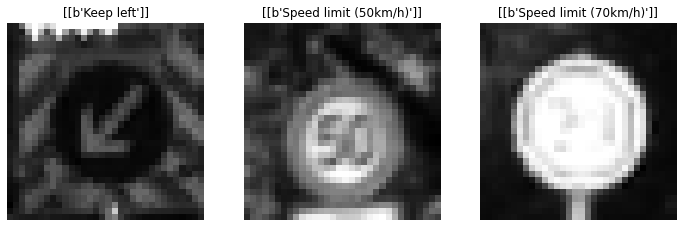

In [23]:
# Show some examples
num_plots = 3
idx = np.random.choice(train_images.shape[0], num_plots)

plt.figure(figsize=(12, 4))
for i in range(num_plots):
    plt.subplot(1, num_plots, i + 1)
    plt.imshow(np.reshape(train_images[idx[i]], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    plt.axis("off")
    #plt.title(str(train_labels[idx[i]]))
    plt.title(label_names[train_labels[idx[i]], 1])
plt.savefig('trafficSignExamples.png')

### Model
We define the model as a nengo network.
We have three convolutional layers with leaky-integrate-and-fire neurons and a dense linear layer for the output

In [22]:
with nengo.Network(seed=0) as net:
    # set some default parameters for the neurons that will make
    # the training progress more smoothly
    net.config[nengo.Ensemble].max_rates = nengo.dists.Choice([100])
    net.config[nengo.Ensemble].intercepts = nengo.dists.Choice([0])
    net.config[nengo.Connection].synapse = None
    neuron_type = nengo.LIF(amplitude=0.01)

    # this is an optimization to improve the training speed,
    # since we won't require stateful behaviour in this example
    nengo_dl.configure_settings(stateful=False)

    # the input node that will be used to feed in input images
    inp = nengo.Node(np.zeros(IMG_SIZE * IMG_SIZE))

    # add the first convolutional layer
    x = nengo_dl.Layer(tf.keras.layers.Conv2D(filters=32, kernel_size=3))(
        inp, shape_in=(32, 32, 1)
    )
    x = nengo_dl.Layer(neuron_type)(x)

    # add the second convolutional layer
    x = nengo_dl.Layer(tf.keras.layers.Conv2D(filters=64, strides=2, kernel_size=3))(
        x, shape_in=(30, 30, 32)
    )
    x = nengo_dl.Layer(neuron_type)(x)

    # add the third convolutional layer
    x = nengo_dl.Layer(tf.keras.layers.Conv2D(filters=128, strides=2, kernel_size=3))(
        x, shape_in=(14, 14, 64)
    )
    x = nengo_dl.Layer(neuron_type)(x)

    # linear readout
    out = nengo_dl.Layer(tf.keras.layers.Dense(units=NUM_CLASSES))(x)
    
    # dropout layer
    #out = nengo_dl.Layer(tf.keras.layers.Dropout(0.3))(out)

    # we'll create two different output probes, one with a filter
    # (for when we're simulating the network over time and
    # accumulating spikes), and one without (for when we're
    # training the network using a rate-based approximation)
    out_p = nengo.Probe(out, label="out_p")
    out_p_filt = nengo.Probe(out, synapse=0.1, label="out_p_filt")

### Training

In [23]:
def classification_accuracy(y_true, y_pred):
    return tf.metrics.sparse_categorical_accuracy(y_true[:, -1], y_pred[:, -1])

minibatch_size = 128
sim = nengo_dl.Simulator(net, minibatch_size=minibatch_size)

|                     Building network (0%)                    | ETA:  --:--:--
|                     Building network (0%)                    | ETA:  --:--:--
|                     Building network (0%)                    | ETA:  --:--:--
|###                   Building network (5%)                     | ETA: 0:00:04
|#######              Building network (11%)                     | ETA: 0:00:02
Build finished in 0:00:00
|#                         Optimizing graph                           | 0:00:00
|#             Optimizing graph: operator simplificaton               | 0:00:00
Optimizing graph: operator simplificaton finished in 0:00:00
|#                Optimizing graph: merging operators                 | 0:00:00
Optimizing graph: merging operators finished in 0:00:00
|#                Optimizing graph: ordering signals                  | 0:00:00
Optimizing graph: ordering signals finished in 0:00:00
|#                Optimizing graph: creating signals                  | 0:00:00
Op

In [24]:
# run training or load pre-trained parameter
do_training = True
NUM_EPOCHS = 10

if do_training:
    sim.compile(
        optimizer=tf.optimizers.RMSprop(0.001),
        loss={out_p: tf.losses.SparseCategoricalCrossentropy(from_logits=True)},
    )
    sim.fit(train_images, {out_p: train_labels}, epochs=NUM_EPOCHS)
    sim.save_params("trafficSign_params")
else:
    sim.load_params("trafficSign_params")

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--
Constructing graph: pre-build stage finished in 0:00:00
|             Constructing graph: build stage (0%)             | ETA:  --:--:--
|##########    Constructing graph: build stage (15%)             | ETA: 0:00:00
|##############Constructing graph: build stage (47%)             | ETA: 0:00:00
|##############Constructing graph: build stage (89%)######       | ETA: 0:00:00
|############Constructing graph: build stage (100%)############| ETA:  00:00:00
Constructing graph: build stage finished in 0:00:00
|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--
Constructing graph: pre-build stage finished in 0:00:00
|             Constructing graph: build stage (0%)             | ETA:  --:--:--
|##########    Constructing graph: build stage (15%)             | ETA: 0:00:00
|##############Constructing graph: build stage (47%)             | ETA: 0:00:00
|##############Constructing graph: b

In [25]:
# Evaluate the model
sim.compile(loss={out_p_filt: classification_accuracy})
print(
    "\nAccuracy after training:",
    sim.evaluate(test_images, {out_p_filt: test_labels}, verbose=0)["loss"],
)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


C:\Users\Alex\AppData\Local\Programs\Python\Python37\lib\site-packages\nengo_dl\simulator.py:1922: UserWarning: Number of elements in input data (12630) is not evenly divisible by Simulator.minibatch_size (128); input data will be truncated.
  f"Number of elements in input data ({data_batch}) is not "
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--
Constructing graph: pre-build stage finished in 0:00:00
|             Constructing graph: build stage (0%)             | ETA:  --:--:--
|############# Constructing graph: build stage (21%)             | ETA: 0:00:00
|##############Constructing graph: build stage (47%)             | ETA: 0:00:00
|##############Constructing graph: build stage (89%)######       | ETA: 0:00:00
|############Constructing graph: build stage (100%)############| ETA:  00:00:00
Constructing graph: build stage finished in 0:00:00
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--
Constructing graph: pre-build stage finished in 0:00:00
|             Constructing graph: build stage (0%)             | ETA:  --:--:--
|############# Constructing graph: build stage (21%)             | ETA: 0:00:00
|##############Constructing graph: build stage (63%)             | ETA: 0:00:00
|############Constructing graph: build stage (100%)############| ETA:  00:00:00
|############Constructing graph: build stage (100%)############| ETA:  00:00:00
Constructing graph: build stage finished in 0:00:00

Accuracy after training: 0.8970822691917419


In [26]:
cm = tf.math.confusion_matrix(test_labels, sim.predict(test_images))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--
Constructing graph: pre-build stage finished in 0:00:00
|             Constructing graph: build stage (0%)             | ETA:  --:--:--
|##########    Constructing graph: build stage (15%)             | ETA: 0:00:00
|##############Constructing graph: build stage (47%)             | ETA: 0:00:00
|##############Constructing graph: build stage (89%)######       | ETA: 0:00:00
|############Constructing graph: build stage (100%)############| ETA:  00:00:00
Constructing graph: build stage finished in 0:00:00


TypeError: '<' not supported between instances of 'Probe' and 'Probe'

In [27]:
cm
#sim.close()

NameError: name 'cm' is not defined